In [ ]:
# Andrew Dunn, Katherine Dumais, Kathryn Link-Oberstar, Lee-Or Bentovim
# Initial exploratory analysis for Costa Rican household poverty level prediction

In [77]:
# Load libraries
import pandas as pd
import numpy as np
from load_data import load_train_data 
import json
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt


### Load Data

In [78]:
# Load data
X_train, X_valid, y_train, y_valid = load_train_data()

# combine the training datasets into one
df = X_train.merge(y_train, left_index = True, right_index = True)

# Load variable descriptions
with open('var_descriptions.json', 'r') as f:
    # Load JSON data as a dictionary
    var_desc = json.load(f)

### Data Cleaning
- There are a few features which are coded as strings but mix strings and integers/floats (see example below):
    - 'dependency', 
    - 'edjefe', 
    - 'edjefa'
    - 'tamviv'

We will need to decide how to handle these.

### Lit review
Below are notes from research papers we consulted. The focus on variables we may create and tips on how we may do our analysis.

[Understanding the Determinants of Poverty](https://web.worldbank.org/archive/website01407/WEB/IMAGES/PMCH8.PDF)

- using the highest level of the individuals in the household as the 
household level characteristic. IE, education level of the most highly educated
person in the household

[Introduction to Poverty Analysis](https://documents1.worldbank.org/curated/en/775871468331250546/pdf/902880WP0Box380okPovertyAnalysisEng.pdf)

- p88 - use household head characteristics

[HOUSEHOLD CHARACTERISTICS AND POVERTY: A LOGISTIC REGRESSION ANALYSIS](https://www.jstor.org/stable/23612271?seq=8)

- p310
    - use presence of disability, able-bodied persons, in the household
    - sex ratio in household
    - child/woman ratio in household
    - proportion of female workers to total workers
    - dependency ratio

[Understanding poverty through household and individual level characteristics](https://worldbank.github.io/SARMD_guidelines/note-hhdchars.html)

- "For example, it is not true in general that female-headed households have lower levels of expenditures per capita"
- "It is true, however, that urban households have significantly higher expenditures per capita"

[The DHS Wealth Index](https://dhsprogram.com/pubs/pdf/cr6/cr6.pdf)

- "For this reason, Filmer and Pritchett recommended using principal components analysis
(PCA) to assign the indicator weights, the procedure that is used for the DHS wealth index."

[Poverty and its measurement](https://www.ine.es/en/daco/daco42/sociales/pobreza_en.pdf)

- p8-9 - calculate income per consumption unit rather than per capita

[ARE POOR INDIVIDUALS MAINLY FOUND IN POOR HOUSEHOLDS? EVIDENCE USING NUTRITION DATA FOR AFRICA](https://www.nber.org/system/files/working_papers/w24047/w24047.pdf)

[Moving from the Household to the Individual: Multidimensional Poverty Analysis](https://arxiv.org/ftp/arxiv/papers/1304/1304.5816.pdf)
- "Using longitudinal data Medeiros and Costa (2008) conclude that
feminisation of poverty has not occurred in the eight Latin American countries they
studied. Their findings are invariant to different measures and definitions of poverty."
- "marital status is an important consideration when discussing poverty incidence"

### Data Exploration

Below, we ran a bivariate regression for each feature (except for 'dependency', 'edjefe', and 'edjefa' - see note about need for data cleaning above) on the Target, filtered out results not significnat at the 5% level and returned:

* the top 5 features by r-squared
    
* the top 5 features by the absolute value of the coefficient

In [79]:
features_to_include = [x for x in var_desc.keys() if x not in ['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']]

df_subset = df[features_to_include]
df_subset 

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
3709,NaN,0,5,0,1,1,1,1.0,0,1,...,169,529,9,0,0,1.000000,0.000000,235.111100,529,4
1182,NaN,0,4,0,1,1,0,NaN,0,1,...,36,6241,4,0,0,1.000000,64.000000,36.000000,6241,4
9153,NaN,0,4,0,1,1,0,NaN,0,1,...,0,9,16,9,4,4.000000,1.000000,4.000000,9,4
2109,180000.0,0,4,0,1,1,0,NaN,0,1,...,144,2116,1,144,0,0.111111,0.000000,144.000000,2116,4
2066,NaN,0,7,0,1,1,1,1.0,0,1,...,289,1600,1,289,0,0.250000,0.000000,289.000000,1600,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,125000.0,0,3,0,1,1,1,1.0,0,1,...,81,900,4,81,0,4.000000,0.000000,100.000000,900,4
6049,NaN,1,3,1,1,0,0,NaN,1,5,...,16,169,100,64,25,25.000000,1.000000,27.039997,169,4
2743,NaN,0,4,0,1,1,0,NaN,0,2,...,225,2025,9,225,0,2.250000,0.000000,196.000000,2025,4
5657,178000.0,0,5,0,1,1,0,NaN,0,2,...,121,441,25,121,4,2.777778,0.444444,121.000000,441,4


In [80]:
# Fill in NaN with the column mean
df_subset = df_subset.fillna(df_subset.mean())

# Select the target column and the other columns of interest & excude the 3 columns discussed above with mixed datatypes 
target_col = 'Target'
other_cols = [x for x in df_subset.columns if x not in ['Target']]
results_df = pd.DataFrame(columns=['variable', 'coefficient', 'p_value', 'r_squared'])

# Iterate over each independent variable in the dataframe
for col in df_subset.columns[:-1]:
    # Fit a linear regression model on the independent variable and target
    X = df_subset[[col]]
    y = df_subset[target_col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    # Get the coefficient, p-value, and R-squared for the model
    coeff = model.params[1]
    p_value = model.pvalues[1]
    r_squared = model.rsquared
    
    results_df.loc[len(results_df)] = [col, coeff, p_value, r_squared]

results_df['variable_desc'] = results_df['variable'].map(var_desc)
print(results_df)

            variable  coefficient        p_value  r_squared   
0               v2a1     0.000002   2.349945e-30   0.017008  \
1             hacdor    -0.972788   4.170707e-59   0.033804   
2              rooms     0.153738   2.459432e-88   0.050622   
3             hacapo    -0.895870   3.957915e-33   0.018638   
4               v14a     0.866027   1.164341e-07   0.003667   
..               ...          ...            ...        ...   
132     SQBhogar_nin    -0.044599  7.923814e-172   0.097124   
133  SQBovercrowding    -0.063836  1.688727e-119   0.068246   
134    SQBdependency    -0.006762   3.934324e-13   0.006869   
135        SQBmeaned     0.003062  5.851780e-136   0.077426   
136            agesq     0.000042   2.233758e-10   0.005253   

                        variable_desc  
0                Monthly rent payment  
1            Overcrowding by bedrooms  
2    Number of all rooms in the house  
3               Overcrowding by rooms  
4         Has toilet in the household  
.. 

In [81]:
# Filter results where p_value is less than or equal to 0.05 and sort by r-squared
results_df = results_df[results_df['p_value'] <= 0.05]
results_df = results_df.sort_values(by='r_squared', ascending = False)
print(results_df.head(5))

         variable  coefficient        p_value  r_squared   
98       meaneduc     0.080755  1.120972e-196   0.110527  \
94      hogar_nin    -0.242501  6.047454e-193   0.108526   
14           r4t1    -0.300630  1.343977e-174   0.098628   
132  SQBhogar_nin    -0.044599  7.923814e-172   0.097124   
19       escolari     0.063796  1.027866e-157   0.089423   

                                   variable_desc  
98   average years of education for adults (18+)  
94       number of children 0 to 19 in household  
14          Persons younger than 12 years of age  
132                            hogar_nin squared  
19                            Years of schooling  


In [82]:
# Filter results where p_value is less than or equal to 0.05 and sort by coefficient
results_df = results_df[results_df['p_value'] <= 0.05]
results_df = results_df.iloc[abs(results_df['coefficient']).argsort()[::-1]] 
print(results_df.head(5))

       variable  coefficient       p_value  r_squared   
33    pisonatur    -1.421876  2.228287e-05   0.002350  \
43  abastaguano    -1.212262  7.133514e-08   0.003791   
60    elimbasu4    -0.976908  3.583327e-03   0.001109   
1        hacdor    -0.972788  4.170707e-59   0.033804   
28  paredfibras    -0.946817  1.804639e-03   0.001273   

                                        variable_desc  
33  Predominant material on the floor is natural m...  
43                                 No water provision  
60  rubbish disposal mainly by throwing in an unoc...  
1                            Overcrowding by bedrooms  
28  Predominant material on the outside wall is na...  


In [83]:
results_df.to_csv('regression_results.csv', index=False)

In [84]:
# Comparison of individual and household level characteristics

In [85]:
Individual = ['v18q', 'tamviv', 'escolari', 'rez_esc', 'dis', 'male', 'female', 'estadocivil1','estadocivil2','estadocivil3','estadocivil4','estadocivil5','estadocivil6',\
'estadocivil7','parentesco1','parentesco2','parentesco3','parentesco4', 'parentesco5', 'parentesco6', 'parentesco7',\
'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11' ,'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9', 'mobilephone']

Household = [
    'v2a1','hacdor',
'rooms', 'hacapo','v14a', 'refrig', 'v18q1', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2','r4m3','r4t1', 'r4t2','r4t3','tamhog','hhsize',
'paredblolad','paredzocalo','paredpreb','pareddes','paredmad','paredzinc','paredfibras','paredother','pisomoscer','pisocemento',
'pisoother','pisonatur','pisonotiene','pisomadera','techozinc', 'techoentrepiso', 'techocane', 'techootro','cielorazo','abastaguadentro',
'abastaguafuera','abastaguano', 'public','planpri','noelec','coopele','sanitario1','sanitario2','sanitario3','sanitario5','sanitario6','energcocinar1',
'energcocinar2','energcocinar3','energcocinar4','elimbasu1','elimbasu2','elimbasu3','elimbasu4','elimbasu5','elimbasu6','epared1','epared2','epared3','etecho1',
'etecho2','etecho3','eviv1','eviv2','eviv3',#'idhogar',
'hogar_nin','hogar_adul','hogar_mayor','hogar_total',#'dependency',#'edjefe','edjefa',
'meaneduc','bedrooms','overcrowding','tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5','computer','television','qmobilephone',
'lugar1','lugar2','lugar3','lugar4','lugar5','lugar6',
'area1','area2']

If we split on these we learn the following:

In [86]:
df_subset2 = df_subset.copy() 
df_subset = df_subset[Household].fillna(df_subset[Household].mean())

# Select the target column and the other columns of interest
target_col = "Target"
other_cols = Household

# Create an empty dataframe to store the regression results
results_df = pd.DataFrame(columns=["variable", "coefficient", "p_value", "r_squared"])

# Iterate over each independent variable in the dataframe
for col in df_subset.columns[:-1]:
    # Fit a linear regression model on the independent variable and target
    X = df_subset[[col]]
    y = y_train["Target"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # Get the coefficient, p-value, and R-squared for the model
    coeff = model.params[1]
    p_value = model.pvalues[1]
    r_squared = model.rsquared

    # Add the results to the results dataframe
    results_df.loc[len(results_df)] = [col, coeff, p_value, r_squared]

# Add a column with the variable descriptions
results_df["variable_desc"] = results_df["variable"].map(var_desc)

# Filter the results where p_value is less than or equal to 0.05
results_df = results_df[results_df["p_value"] <= 0.05]

# Sort the results by r-squared from least to greatest
results_df = results_df.sort_values(by="r_squared", ascending=False)

# Print the results dataframe
print(results_df)

          variable  coefficient        p_value  r_squared   
72        meaneduc     0.080755  1.120972e-196   0.110527  \
68       hogar_nin    -0.242501  6.047454e-193   0.108526   
13            r4t1    -0.300630  1.343977e-174   0.098628   
36       cielorazo     0.638890  6.784136e-156   0.088426   
74    overcrowding    -0.361997  3.274840e-152   0.086403   
..             ...          ...            ...        ...   
56       elimbasu4    -0.976908   3.583327e-03   0.001109   
42          noelec    -0.643940   6.657750e-03   0.000963   
35       techootro     0.692177   1.008356e-02   0.000866   
33  techoentrepiso     0.190463   3.039188e-02   0.000613   
32       techozinc     0.144453   3.379452e-02   0.000589   

                                        variable_desc  
72        average years of education for adults (18+)  
68            number of children 0 to 19 in household  
13               Persons younger than 12 years of age  
36                                  House h

In [87]:
df_subset = df_subset2.copy()
df_subset = df_subset[Individual].fillna(df_subset[Individual].mean())

# Select the target column and the other columns of interest
target_col = "Target"
other_cols = Individual 

# Create an empty dataframe to store the regression results
results_df = pd.DataFrame(columns=["variable", "coefficient", "p_value", "r_squared"])

# Iterate over each independent variable in the dataframe
for col in df_subset.columns[:-1]:
    # Fit a linear regression model on the independent variable and target
    X = df_subset[[col]]
    y = y_train["Target"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # Get the coefficient, p-value, and R-squared for the model
    coeff = model.params[1]
    p_value = model.pvalues[1]
    r_squared = model.rsquared

    # Add the results to the results dataframe
    results_df.loc[len(results_df)] = [col, coeff, p_value, r_squared]

# Add a column with the variable descriptions
results_df["variable_desc"] = results_df["variable"].map(var_desc)

df_subset=df_subset2.copy()

# Filter the results where p_value is less than or equal to 0.05
results_df = results_df[results_df["p_value"] <= 0.05]

# Sort the results by r-squared from least to greatest
results_df = results_df.sort_values(by="r_squared", ascending=False)

# Print the results dataframe
print(results_df)

        variable  coefficient        p_value  r_squared   
2       escolari     0.063796  1.027866e-157   0.089423  \
0           v18q     0.561255   4.283957e-97   0.055608   
31    instlevel8     0.613720   2.505349e-78   0.044895   
1         tamviv    -0.084752   2.108554e-44   0.025243   
27    instlevel2    -0.420081   1.126248e-43   0.024818   
26    instlevel1    -0.425687   1.074212e-36   0.020731   
7   estadocivil1    -0.394486   3.489173e-32   0.018083   
9   estadocivil3     0.292192   9.319299e-30   0.016656   
32    instlevel9     0.701181   2.202417e-13   0.007017   
19   parentesco6    -0.301802   6.379435e-09   0.004402   
11  estadocivil5    -0.225072   2.087719e-06   0.002941   
4            dis    -0.228945   4.469559e-06   0.002751   
16   parentesco3    -0.102964   1.327795e-05   0.002479   
15   parentesco2     0.126881   1.938825e-05   0.002385   
10  estadocivil4     0.269694   4.014296e-05   0.002204   
14   parentesco1     0.090992   2.529281e-04   0.001751 

This demonstrates that on an individual level the Household characteristics provide a lot more explanitory value than the individual characteristics. Understanding that poverty does not exist in a vacuum-- the conditions of someones family and environment are important factors in understanding their financial status. 

In [88]:
# Correlation of variables with Target
no_target_df, _, target, _ = load_train_data()
df = no_target_df.copy()
df['Target'] = target
corrs = abs(no_target_df.corrwith(df.loc[:,'Target'], method='spearman')).sort_values(ascending=False)
corrs.head(10)


/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


meaneduc         0.374465
SQBmeaned        0.374465
v2a1             0.358491
SQBdependency    0.342857
escolari         0.308858
SQBescolari      0.308858
cielorazo        0.307604
hogar_nin        0.304379
SQBhogar_nin     0.304379
eviv3            0.296193
dtype: float64

In [89]:
df['Target'].value_counts()

Target
4    4817
2    1262
3     970
1     596
Name: count, dtype: int64

In [90]:
# define logged value of the var
# should be moved to load_data file eventually
df['v2a1_log'] = np.log1p(df['v2a1'].fillna(np.mean(df['v2a1'])))

In [91]:
# Define functions to plot data
def plot_continuous(df, continuous_col, target_col, cutoff=None):
    """
    Plot target distribution by continuous variable
    
    Parameters:
    df (pandas.DataFrame): Dataframe containing both continuous and target variables
    continuous_col (str): Name of the continuous variable column
    target_col (str): Name of the target variable column
    cutoff (float): Optional cutoff value for the continuous variable
    
    Returns:
    None
    """
    df[continuous_col] = df[continuous_col].fillna(df[continuous_col].mean())
    
    # Cap continuous column at cutoff if specified
    if cutoff:
        df.loc[df[continuous_col] > cutoff, continuous_col] = cutoff
    
    # Define the bins using the distribution of the continuous variable
    if cutoff:
        bins = [df[continuous_col].min(), df[continuous_col].quantile(0.25), df[continuous_col].median(), df[continuous_col].quantile(0.75), cutoff]
    else:
        bins = np.percentile(df[continuous_col], [0, 25, 50, 75, 100])
    bins = np.unique(bins)
    # Create a label for each bin, handling duplicates if necessary
    labels = []
    for i in range(len(bins)-1):
        label = f'{int(bins[i])}-{int(bins[i+1])}'
        count = labels.count(label)
        if count > 0:
            label = f'{label} ({count})'
        labels.append(label)
    
    df[f'{continuous_col}_bin'] = pd.cut(df[continuous_col], bins=bins, labels=labels, include_lowest=True, right=True, duplicates='drop')
    
    # Count target variable by continuous variable bin
    target_by_bin = df.groupby(f'{continuous_col}_bin')[target_col].value_counts(normalize=True).unstack().fillna(0)
    
    # Define the x-axis tick labels
    tick_labels = labels
    
    # Plot the bars
    fig, ax = plt.subplots()
    bar_width = 0.2
    opacity = 0.8
    
    for i in range(len(target_by_bin.columns)):
        rects = ax.bar(np.arange(len(tick_labels))+i*bar_width, target_by_bin.iloc[:,i], bar_width, alpha=opacity, label=f'Target = {target_by_bin.columns[i]}')
    
    # Add axis labels, title, and legend
    ax.set_xlabel(continuous_col)
    ax.set_ylabel('Percentage')
    ax.set_title(f'Target Distribution by {continuous_col}')
    ax.set_xticks(np.arange(len(tick_labels))+0.5*(len(target_by_bin.columns)-1)*bar_width)
    ax.set_xticklabels(tick_labels)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_grouped_bar_chart(df, binary_col, target_col):
    """
    Plots a grouped bar chart showing the percentage of each target category for each value of a binary column.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    binary_col (str): The name of the binary column.
    target_col (str): The name of the target column.

    Returns:
    None
    """

    # Create a grouped bar chart
    fig, ax = plt.subplots()
    bar_width = 0.35
    opacity = 0.8

    # Get the unique values of the binary column
    index = df[binary_col].unique()

    # Count target variable by binary group
    binary_yes = df[df[binary_col] == 1][target_col].value_counts().sort_index().tolist()
    binary_no = df[df[binary_col] == 0][target_col].value_counts().sort_index().tolist()

    # Calculate percentage of total for each target category within each binary group
    binary_yes_perc = [count/sum(binary_yes) * 100 for count in binary_yes]
    binary_no_perc = [count/sum(binary_no) * 100 for count in binary_no]
    binary_yes_target_perc = [binary_yes[i]/(binary_yes[i]+binary_no[i]) * 100 for i in range(len(binary_yes))]
    binary_no_target_perc = [binary_no[i]/(binary_yes[i]+binary_no[i]) * 100 for i in range(len(binary_no))]

    # Define the x-axis tick labels
    tick_labels = sorted(df[target_col].unique())

    # Plot the bars
    rects1 = ax.bar([i - bar_width/2 for i in range(len(tick_labels))], binary_yes_target_perc, bar_width, alpha=opacity, color='b', label=f'{binary_col}=Yes')
    rects2 = ax.bar([i + bar_width/2 for i in range(len(tick_labels))], binary_no_target_perc, bar_width, alpha=opacity, color='orange', label=f'{binary_col}=No')

    # Add axis labels, title, and legend
    ax.set_xlabel(target_col)
    ax.set_ylabel('Percentage of Total')
    ax.set_title(f'{target_col} count by {binary_col}')
    ax.set_xticks([i for i in range(len(tick_labels))])
    ax.set_xticklabels(tick_labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [92]:
# Plot variables with the highest correlation with Target and other variables of interest

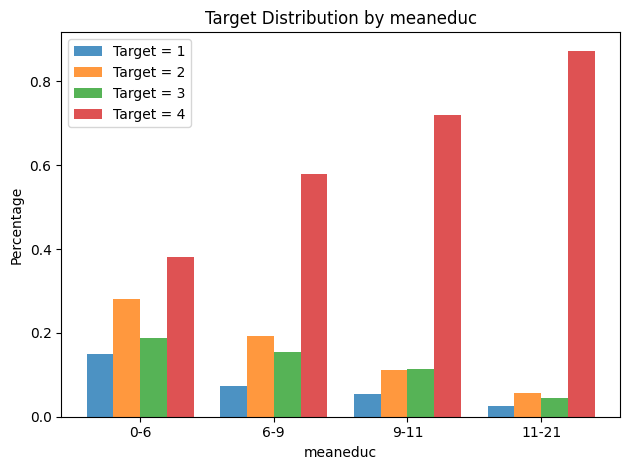

In [93]:
plot_continuous(df, 'meaneduc', 'Target', cutoff=21)

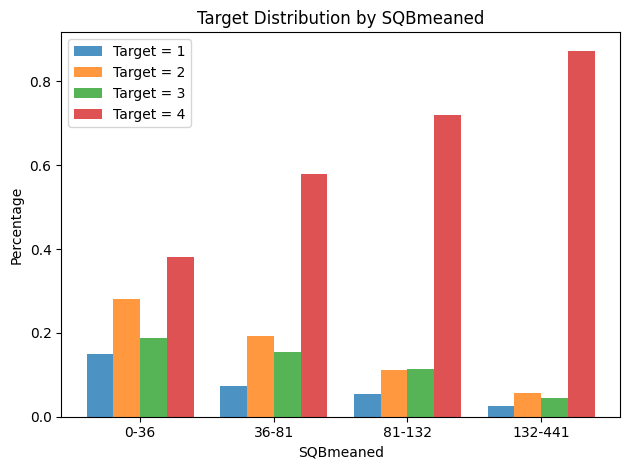

In [94]:
plot_continuous(df, 'SQBmeaned', 'Target', cutoff=441)

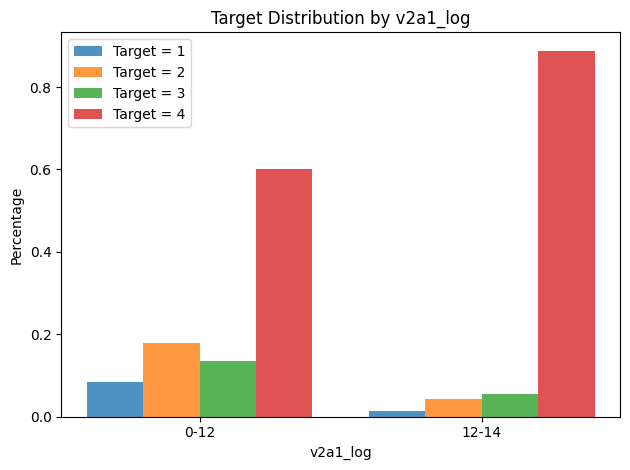

In [95]:
plot_continuous(df,'v2a1_log','Target')

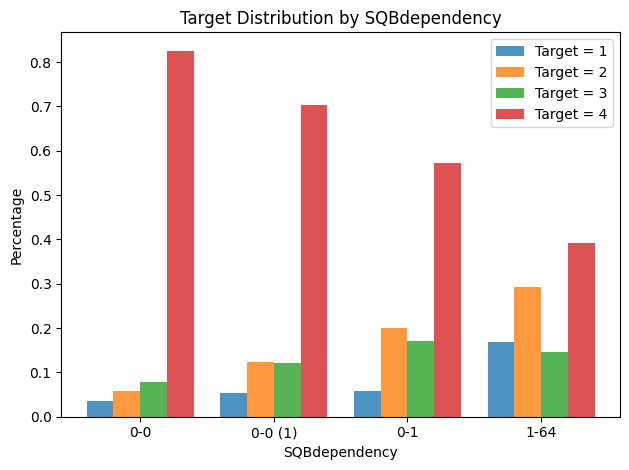

In [96]:
plot_continuous(df,'SQBdependency','Target')

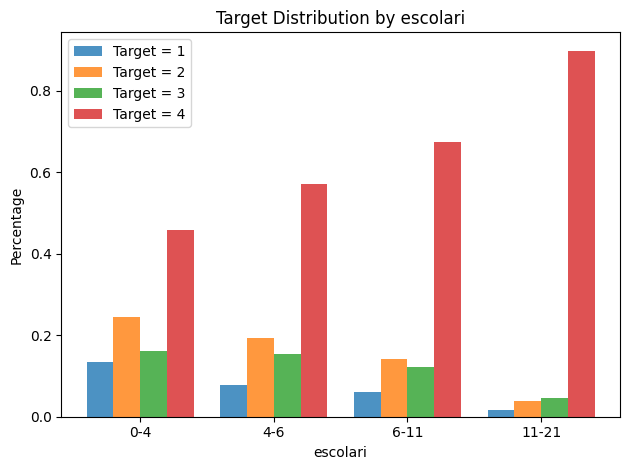

In [97]:
plot_continuous(df,'escolari','Target')

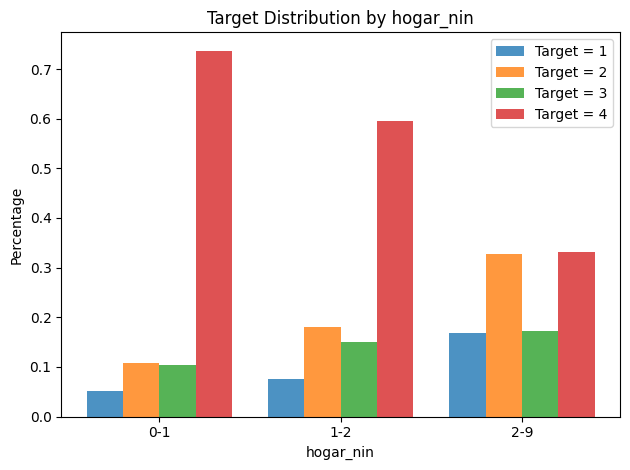

In [98]:
plot_continuous(df,'hogar_nin','Target')

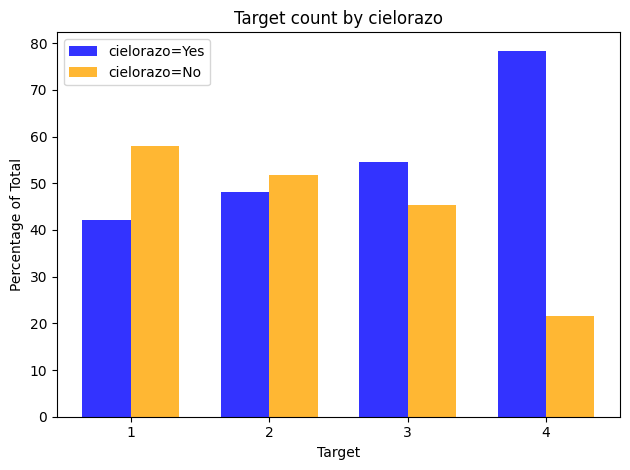

In [99]:
plot_grouped_bar_chart(df, 'cielorazo', 'Target')

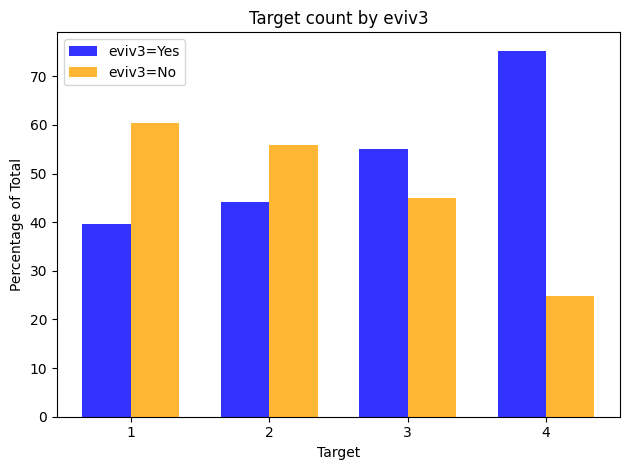

In [100]:
plot_grouped_bar_chart(df, 'eviv3', 'Target')

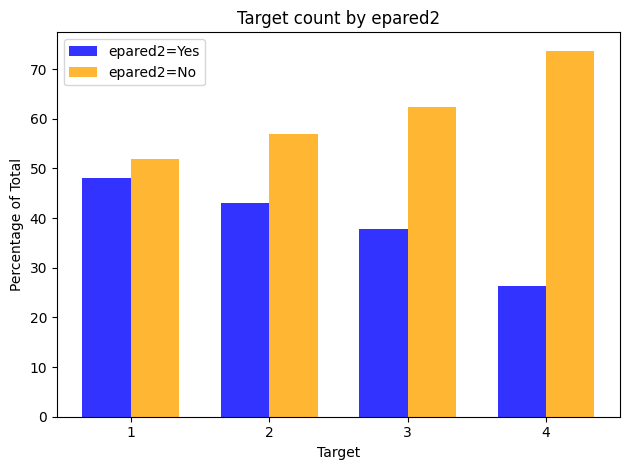

In [101]:
plot_grouped_bar_chart(df,'epared2','Target')

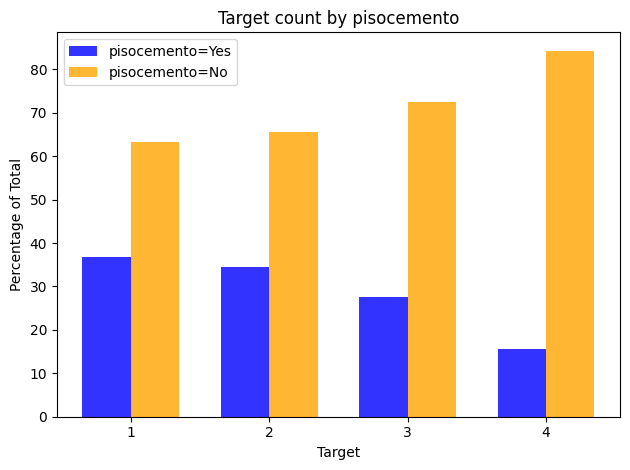

In [102]:
plot_grouped_bar_chart(df,'pisocemento','Target')

Generally it seems easy to classify the relatively wealthy, and hard to classify the relatively poor, even with the highest correlation variables